In [1]:
"""
@author: Crazy Trader
Trading Hours (HKT Timezone) Mon - Fri: 
    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30
                   (Night Session)  : 17:15 - 01:00
    HK Equities    (Auction Session): 09:00 - 09:30
                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08
    US Equities                     : 22:30 - 05:00
    Forex                           : 00:00 - 23:59
Restrictions:
    Trading must be in trading hours
    Trading must be in sufficnet cash
    Option Strike Price is in step of 200
Assumptions:
    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options
    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year
    no overnight fee incurred
Operations:
    Long with Ask
    Short with Bid
"""

'\n@author: Crazy Trader\nTrading Hours (HKT Timezone) Mon - Fri: \n    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30\n                   (Night Session)  : 17:15 - 01:00\n    HK Equities    (Auction Session): 09:00 - 09:30\n                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08\n    US Equities                     : 22:30 - 05:00\n    Forex                           : 00:00 - 23:59\nRestrictions:\n    Trading must be in trading hours\n    Trading must be in sufficnet cash\n    Option Strike Price is in step of 200\nAssumptions:\n    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options\n    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year\n    no overnight fee incurred\nOperations:\n    Long with Ask\n    Short with Bid\n'

In [2]:
#%% Library
from functions import *

In [3]:
#%%
initdataset()                                               # initialize Dataset

In [7]:
#%%
initportfolio(10000000, 100)                                # initialize Account Cash, service fee
start   = '2018-09-01 00:00:00'                             # initialize start date
end     = '2019-10-01 23:59:59'                             # initialize start date
mask = (quote['USDHKD'].index > start) & (quote['USDHKD'].index <= end)
backtestperiod = quote['USDHKD'].loc[mask]
count = 0

In [8]:
for time, reference in backtestperiod.iterrows():
    """ 
    Examples:
    print (quote['HSI'].loc[time].Close, quote['HSI'].loc[time].Volume, quote['VIX'].loc[time].Close)
    trade(time, 'XRPUSD', 'LONG', quote['XRPUSD'].loc[time].Ask, 100000)
    trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Bid, 100000)
    trade(time, 'HSI', 'SHORT', quote['HSI'].loc[time].Close, 10)
    trade(time, 'CALL', 'SHORT', quote['HSI'].loc[time].Close, 100, 26000, 8)
    trade(time, 'HSI', 'CLOSE', quote['HSI'].loc[time].Close, 10)
    trade(time, 'CALL', 'CLOSE', quote['HSI'].loc[time].Close, 0, 0, 0)
    """
    count = count + 1
    if count == 1:
        trade(time, 'HSI', 'LONG', quote['HSI'].loc[time].Close, 100)
    elif count == 20:
        trade(time, 'XRPUSD', 'SHORT', quote['XRPUSD'].loc[time].Ask, 100000)
    elif count == 40:
        trade(time, 'HSI', 'CLOSE', quote['HSI'].loc[time].Close, 100)
    elif count == 80:
        trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Bid, 100000)
    elif count == 100:
        trade(time, 'HSI', 'LONG', quote['HSI'].loc[time].Close, 100)
    elif count == 120:
        trade(time, 'XRPUSD', 'SHORT', quote['XRPUSD'].loc[time].Ask, 100000)
    elif count == 140:
        trade(time, 'HSI', 'CLOSE', quote['HSI'].loc[time].Close, 100)
    elif count == 180:
        trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Bid, 100000)
    elif count == 200:
        trade(time, 'HSI', 'LONG', quote['HSI'].loc[time].Close, 100)
    elif count == 220:
        trade(time, 'XRPUSD', 'SHORT', quote['XRPUSD'].loc[time].Ask, 100000)
    elif count == 240:
        trade(time, 'HSI', 'CLOSE', quote['HSI'].loc[time].Close, 100)
    elif count == 280:
        trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Bid, 100000)
    elif count > 1000:
        break
    ### ADD YOUR CODE HERE ###
    
    ### ADD YOUR CODE HERE ###
    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        updatepos(time)

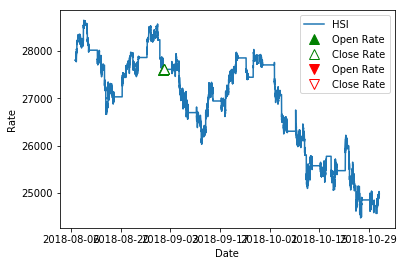

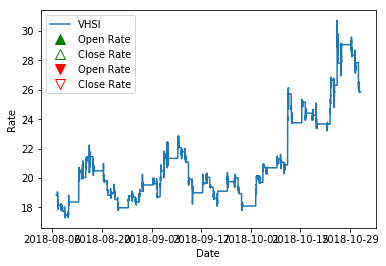

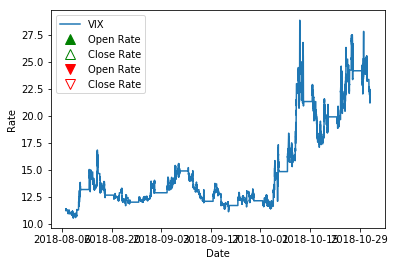

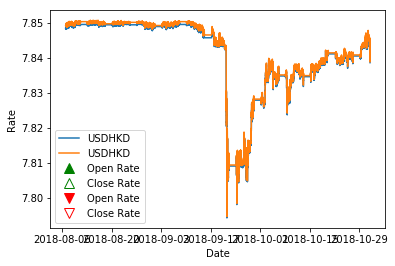

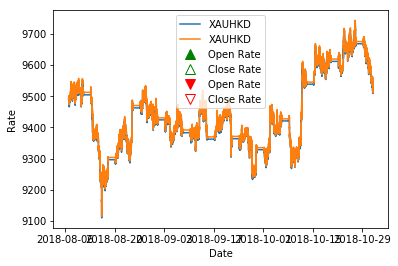

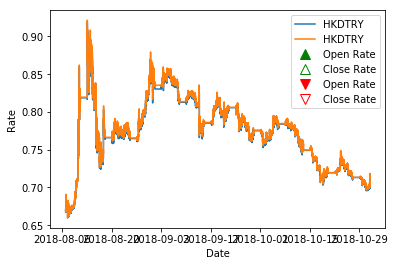

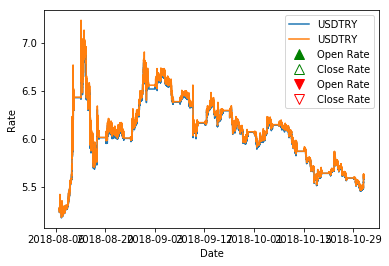

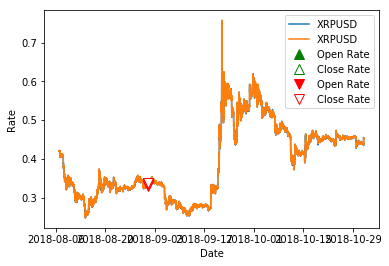

  Product Strike Maturity Position           Open Date    Open Rate     Qty  \
0     HSI   None     None     LONG 2018-09-01 00:01:00  27608.00000     100   
1  XRPUSD   None     None    SHORT 2018-09-01 00:20:00      0.33116  100000   
2     HSI   None     None     LONG 2018-09-01 01:40:00  27613.00000     100   
3  XRPUSD   None     None    SHORT 2018-09-01 02:00:00      0.33768  100000   
4     HSI   None     None     LONG 2018-09-01 03:20:00  27613.00000     100   
5  XRPUSD   None     None    SHORT 2018-09-01 03:40:00      0.33660  100000   

            Close Date Close Rate  Handling  Unrealized P&L Realized P&L  \
0  2018-09-01 00:40:00      27595       200               0        -1500   
1  2018-09-01 01:20:00    0.33295       200               0     -1604.92   
2  2018-09-01 02:20:00      27613       200               0         -200   
3  2018-09-01 03:00:00    0.33668       200               0       584.84   
4  2018-09-01 04:00:00      27613       200               0       

In [9]:
#%% Export Portfolio
portfolio, log = exporttrades()
print (log)
print (portfolio)